# **Swarm Robotics Competitions**

### 2021/2022      

## A. Pedro Aguiar
<pedro.aguiar@fe.up.pt>
<br>

<br> FEUP Nov. 2021


# Competition Swarm Robotics



### **A swarm of 5 agents with a leader agent** steering to resource $R_1$


Consider a fleet of n=5 agents (robots), and let agent 1 be the leader.

Consider also that:
- leader 1 has access to its position $\xi_1$
- all the other agents only have access to the relative position with respect to the other agents, that is, $\xi_{ij}=\xi_i-\xi_j$.  This is only true if they are close to each other (maximum range of 2m), otherwise the relative position is null.
- all the agents have access to the closest distance and angle (direction) of the nearest obstacle, that is, $d_{io}$ and $\theta_{io}$.

**Goal:** Reach the resource $R_1$ with at least 2 agents.

**Solution:** From the notebook "*Motion control of a single agent*", one option is to assign to agent 1 (leader) the feedback control law

$$
u_1 = - K_1 (\xi_1-\xi_d) + \frac{k_{1o}(d_{1o})}{d_{1o}^2} ( \xi_1 - \xi_o ) + \dot{\xi}_d, \quad
k_{1o}(d_{1o}) = \bar k_{1o}e^{-c d_{1o}^2},
$$

where
$K_1, k_{1o}, c$ are positive gains, $d_{1o}$ is the range to the nearest obstacle, $\xi_o$ is the center of the obstacle, and 

$$
\xi_d = R_1, \quad \dot\xi_d = 0
$$







Note that the above law cannot be implementable because we don't know $\xi_0$ !

But we can consider $\xi_0$ to be the closest point of the obstacle to the agent. In that case, we get $\xi_0= \xi_1+[d_{1o}\cos\theta_{1o}, d_{1o}\sin\theta_{1o}]^T$, and therefore, the control law simplifies to

$$
u_1 = - K_1 (\xi_1-\xi_d) - \frac{k_{1o}(d_{1o})}{d_{1o}} 
\left[
\begin{array}{c}
\cos\theta_{1o} \\
\sin\theta_{1o}
\end{array}
\right]
$$
where $d_{1o}$ and $\theta_{1o}$ is the range and angle of agent $i$ to the nearest obstacle.

To make sure that the other agents follow the leader, we set 

$$
u_i = - K_i \sum_{j\in N_i}\big(\xi_{ij} -b_{ij}\big) + \sum_{j= 1}^n \frac{k_{ij}(d_{ij})}{d_{ij}^2}  \xi_{ij} - \frac{k_{io}(d_{io})}{d_{io}} 
\left[
\begin{array}{c}
\cos\theta_{io} \\
\sin\theta_{io}
\end{array}
\right]
+
\dot \xi_d, \quad i=2, 3,\ldots n
$$

$$
d_{ij} = ||\xi_{ij}||, \quad
%d_{io} = ||\xi_i - \xi_o ||
$$



where $K_i$ is a $2\times 2$ positive-definite matrix gain, and the bias terms $b_{ij}= -b_{ji}$ specifies the formation configuration.



In [1]:
import math
import numpy as np
from dynamic_systems import Integrator, Line, Ellipse, World, ConvexPolygon, check_collisions, proximity, closest_drones, food_base_check

# World arena
arena = ConvexPolygon([[ 10.0, -10.0 ],
                       [ 10.0, 10.0 ],
                       [ -10.0, 10.0 ],
                       [ -10.0, -10.0]])

# base = ConvexPolygon([[ -5.0, -10.0 ], # MUDAR ISTO
#                        [ -5.0, -5.0 ],
#                        [ -10.0, -5.0 ],
#                        [ -10.0, -10.0]])

# World obstacles
obs1 = Ellipse(center = [-1.0, -1.0], angle = np.radians(30.0), axes = [3.0, 1.5])
obs2 = Ellipse(center = [-5.0, 1.0], angle = np.radians(0.0), axes = [1.0, 0.4])
#obs3 = ConvexPolygon([[ 4.0, 0.0 ],
#                      [ 5.0, 1.0 ],
#                      [ 6.0, 0.0 ],
#                      [ 4.0, -1.0]])

# Food
food = {1: [0,7.5], 2:[0,0]}
dot_xid = (0,0)
looking_for = 0

# Base
x_base = (-7.5,-7.5)
#print(food[2][1])

# Define world
world = World(arena)
#world.add_obstacle(obs1)
#world.add_obstacle(obs2)
#world.add_obstacle(base)

#world.add_obstacle(obs3)



#######################
# Dynamics: States=[xi] Control=[u] where xi_dot=u
initial_state1 = [0.0, -8.0]
initial_control1 = [0.0, 0.0]
robot1 = Integrator(initial_state1, initial_control1)

initial_state2 = [0.5, -8.0]
initial_control2 = [0.0, 0.0]
robot2 = Integrator(initial_state2, initial_control2)

initial_state3 = [1.0, -8.0]
initial_control3 = [0.0, 0.0]
robot3 = Integrator(initial_state3, initial_control3)

initial_state4 = [1.5, -8.0]
initial_control4 = [0.0, 0.0]
robot4 = Integrator(initial_state4, initial_control4)

initial_state5 = [2.0, -8.0]
initial_control5 = [0.0, 0.0]
robot5 = Integrator(initial_state5, initial_control5)

dt = 0.1
sim_time = 100
time = []
ux1, uy1 = [], []
x1, y1 = [], []
ux2, uy2 = [], []
x2, y2 = [], []
ux3, uy3 = [], []
x3, y3 = [], []
ux4, uy4 = [], []
x4, y4 = [], []
ux5, uy5 = [], []
x5, y5 = [], []
xdv, ydv = [], []

distance41 = []
distance21 = []
distance31 = []
distance51 = []
distance23 = []

cpx1, cpy1 = [], []
cpx2, cpy2 = [], []
cpx3, cpy3 = [], []
cpx4, cpy4 = [], []
cpx5, cpy5 = [], []

R1 = np.array([5, 5])
do = np.zeros((5)) # Distance to obstacle


# Matrices 
c_mtx = np.zeros((5)) # Collision matrix
d_mtx = np.zeros((5)) # Damaged matrix
l_mtx = np.zeros((5)) # Lost matrix
food_delivered = np.zeros((2)) # Delivered food
w_food_mtx = np.zeros((5)) # Matrix that tells if a pair of drones cought some food
time_score = np.array([999,999,999,999]) # 0 - caught food 1, 1 - caught food 2, 2 - left food 1 in base, 3 - left food 2 in base

In [2]:

# Gain matrix
kx, ky = 1, 1
K = np.diag([kx,ky])

K1o_init = 1*np.diag([1,1])
c_d = 5 # Drones
c_o = 5 # 1 Obstacle

K2o_init = 1*K1o_init
K2j_init = K1o_init
K3o_init = 1*K1o_init
K3j_init = K1o_init
K4o_init = 1*K1o_init
K4j_init = K1o_init
K5o_init = 1*K1o_init
K5j_init = K1o_init

b12 = [0.15, 0.0]
b23 = [0.15, 0.0]
#b34 = [0.1, 0.0]
b45 = [0.15, 0.0]
b41 = [0.15, 0.0]




for t in np.linspace(0.0, sim_time, num=int(sim_time/dt)):

    # Time
    time.append(t)

    # Reference signal
#    xid = 10*np.array([ math.sin(t), math.cos(t) ])
#    dot_xid = 10*np.array([ math.cos(t), -math.sin(t) ])
#    xid = 5*np.array([ np.heaviside(t-5,1.0), 0 ])
    
    #xid = food[1]



    # Get the state
    state1 = robot1.get_state()
    state2 = robot2.get_state()
    state3 = robot3.get_state()
    state4 = robot4.get_state()
    state5 = robot5.get_state()
    
    #print(do[0][0])

    if not 1 in w_food_mtx and not 2 in w_food_mtx:
        xid = food[1]
        looking_for = 1
    elif 1 in w_food_mtx and not 2 in w_food_mtx:
        xid = food[2]
        looking_for = 2
    elif 2 in w_food_mtx and not 1 in w_food_mtx:
        xid = food[1]
        looking_for = 1
    elif 1 in w_food_mtx and 2 in w_food_mtx:
        xid = x_base
    
    
    
    
    # Control law
    # Drone 1 - Leader
    closest_pt, do[0] = world.compute_closest(state1)
    #print('do[0]:',do[0])
    angle = np.arctan2(closest_pt[1]-state1[1],closest_pt[0]-state1[0])
    cpx1.append(closest_pt[0])
    cpy1.append(closest_pt[1])
    #xi12 = state1 - state2   
    #xi13 = state1 - state3
    #xi14 = state1 - state4
    #xi15 = state1 - state5
    #print(do[0])
#    u_control1 = - K @ ( state1 - xid ) + (1/do[0]**2)*K1o_init*np.exp(-c*do[0]**2) @ ( state1 - xo ) + dot_xid
#    u_control1 = - K @ ( state1 - xid ) + (1/do[0]**2)*K1o_init*np.exp(-c*do[0]**2) @ ( state1 - closest_pt ) + dot_xid
    u_control1 = - 0.5*K @ ( state1 - xid ) - (1/do[0])*K1o_init*np.exp(-c_o*do[0]**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    #+ (1/np.linalg.norm(xi12)**2)*K2j_init*np.exp(-c_d*np.linalg.norm(xi12)**2) @ xi12
    #+ (1/np.linalg.norm(xi13)**2)*K2j_init*np.exp(-c_d*np.linalg.norm(xi13)**2) @ xi13
    #+ (1/np.linalg.norm(xi14)**2)*K2j_init*np.exp(-c_d*np.linalg.norm(xi14)**2) @ xi14
    #+ (1/np.linalg.norm(xi15)**2)*K2j_init*np.exp(-c_d*np.linalg.norm(xi15)**2) @ xi15
#    u_control1 = - K @ ( state1 - xid ) + dot_xid
#    u_control1 = (0,0)
    #print('u_control1 before satur:',u_control1)
    u_control1 = np.clip(u_control1, -1, 1)
#    print("Distance = " + str(do[0]))
#    print("angle [deg] = " + str(angle*180/np.pi))
#    print("Closest point = " + str(closest_pt))

    # Drone 2 - Dummy
    closest_pt, do[1] = world.compute_closest(state2)
    angle = np.arctan2(closest_pt[1]-state2[1],closest_pt[0]-state2[0])
    cpx2.append(closest_pt[0])
    cpy2.append(closest_pt[1])
    xi21 = state2 - state1   
    xi23 = state2 - state3
    xi24 = state2 - state4
    #xi25 = state2 - state5
    u_control2 = - K @ ((xi21+b12)+(xi23-b23))
    + (1/np.linalg.norm(xi21)**2)*K2j_init*np.exp(-c_d*np.linalg.norm(xi21)**2) @ xi21
    + (1/np.linalg.norm(xi23)**2)*K2j_init*np.exp(-c_d*np.linalg.norm(xi23)**2) @ xi23
    + (1/np.linalg.norm(xi24)**2)*K2j_init*np.exp(-c_d*np.linalg.norm(xi24)**2) @ xi24
    #+ (1/np.linalg.norm(xi25)**2)*K2j_init*np.exp(-c_d*np.linalg.norm(xi25)**2) @ xi25
    - (1/do[1])*K2o_init*np.exp(-c_o*do[1]**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    u_control2 = np.clip(u_control2, -1, 1)

    # Drone 3
    closest_pt, do[2] = world.compute_closest(state3)
    angle = np.arctan2(closest_pt[1]-state3[1],closest_pt[0]-state3[0])
    cpx3.append(closest_pt[0])
    cpy3.append(closest_pt[1])
    xi31 = state3 - state1    
    xi32 = state3 - state2  
    xi34 = state3 - state4
    #xi35 = state3 - state5    
    u_control3 = - K @ ((xi32+b23))
    + (1/np.linalg.norm(xi32)**2)*K3j_init*np.exp(-c_d*np.linalg.norm(xi32)**2) @ xi32
    + (1/np.linalg.norm(xi31)**2)*K3j_init*np.exp(-c_d*np.linalg.norm(xi31)**2) @ xi31
    + (1/np.linalg.norm(xi34)**2)*K3j_init*np.exp(-c_d*np.linalg.norm(xi34)**2) @ xi34
    #+ (1/np.linalg.norm(xi35)**2)*K3j_init*np.exp(-c_d*np.linalg.norm(xi35)**2) @ xi35
    - (1/do[2])*K3o_init*np.exp(-c_o*do[2]**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    u_control3 = np.clip(u_control3, -1, 1)

    # Drone 4
    closest_pt, do[3] = world.compute_closest(state4)
    angle = np.arctan2(closest_pt[1]-state4[1],closest_pt[0]-state4[0])
    cpx4.append(closest_pt[0])
    cpy4.append(closest_pt[1])
    xi41 = state4 - state1    
    xi42 = state4 - state2
    xi43 = state4 - state3    
    #xi45 = state4 - state5    
    #u_control4 = - K @ ((xi41-b41) + (xi45+b45))
    u_control4 = - K @ ((xi41-b41))
    + (1/np.linalg.norm(xi41)**2)*K4j_init*np.exp(-c_d*np.linalg.norm(xi41)**2) @ xi41 
    + (1/np.linalg.norm(xi42)**2)*K4j_init*np.exp(-c_d*np.linalg.norm(xi42)**2) @ xi42 
    + (1/np.linalg.norm(xi43)**2)*K4j_init*np.exp(-c_d*np.linalg.norm(xi43)**2) @ xi43
    #+ (1/np.linalg.norm(xi45)**2)*K4j_init*np.exp(-c_d*np.linalg.norm(xi45)**2) @ xi45
    - (1/do[3])*K4o_init*np.exp(-c_o*do[3]**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    u_control4 = np.clip(u_control4, -1, 1)

    # # Drone 5
    # closest_pt, do[4] = world.compute_closest(state5)
    # angle = np.arctan2(closest_pt[1]-state5[1],closest_pt[0]-state5[0])
    # cpx5.append(closest_pt[0])
    # cpy5.append(closest_pt[1])
    xi51 = state5 - state1    
    # xi52 = state5 - state2
    # xi53 = state5 - state3    
    # xi54 = state5 - state4    
    # u_control5 = - K @ ((xi54-b45))
    # + (1/np.linalg.norm(xi51)**2)*K5j_init*np.exp(-c_d*np.linalg.norm(xi51)**2) @ xi51 
    # + (1/np.linalg.norm(xi52)**2)*K5j_init*np.exp(-c_d*np.linalg.norm(xi52)**2) @ xi52 
    # + (1/np.linalg.norm(xi53)**2)*K5j_init*np.exp(-c_d*np.linalg.norm(xi53)**2) @ xi53
    # + (1/np.linalg.norm(xi54)**2)*K5j_init*np.exp(-c_d*np.linalg.norm(xi54)**2) @ xi54 
    # - (1/do[4])*K5o_init*np.exp(-c_o*do[4]**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    # u_control5 = np.clip(u_control5, -1, 1)






    ############
    # OLD SHIT #
    ############

    # # Drone 2
    # closest_pt, do[1] = world.compute_closest(state2)
    # angle = np.arctan2(closest_pt[1]-state2[1],closest_pt[0]-state2[0])
    # cpx2.append(closest_pt[0])
    # cpy2.append(closest_pt[1])
    # xi21 = state2 - state1    
    # xi23 = state2 - state3
    # xi24 = state2 - state4    
    # xi25 = state2 - state5    
    # u_control2 = - K @ ((xi21+b12)+(xi23-b23)) \
    # + (1/np.linalg.norm(xi21)**2)*K2j_init*np.exp(-c*np.linalg.norm(xi21)**2) @ xi21 \
    # + (1/np.linalg.norm(xi23)**2)*K2j_init*np.exp(-c*np.linalg.norm(xi23)**2) @ xi23 \
    # + (1/np.linalg.norm(xi24)**2)*K2j_init*np.exp(-c*np.linalg.norm(xi24)**2) @ xi24 \
    # + (1/np.linalg.norm(xi25)**2)*K2j_init*np.exp(-c*np.linalg.norm(xi25)**2) @ xi25 \
    # - (1/do[1]**2)*K2o_init*np.exp(-c*do[1]**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    # u_control2 = np.clip(u_control2, -1, 1)


    # # Drone 3
    # closest_pt, do[2] = world.compute_closest(state3)
    # angle = np.arctan2(closest_pt[1]-state3[1],closest_pt[0]-state3[0])
    # cpx3.append(closest_pt[0])
    # cpy3.append(closest_pt[1])
    # xi31 = state3 - state1    
    # xi32 = state3 - state2
    # xi34 = state3 - state4    
    # xi35 = state3 - state5    

    # u_control3 = - K @ ((xi32+b23)+(xi34-b34)) \
    # + (1/np.linalg.norm(xi31)**2)*K3j_init*np.exp(-c*np.linalg.norm(xi31)**2) @ xi31 \
    # + (1/np.linalg.norm(xi32)**2)*K3j_init*np.exp(-c*np.linalg.norm(xi32)**2) @ xi32 \
    # + (1/np.linalg.norm(xi34)**2)*K3j_init*np.exp(-c*np.linalg.norm(xi34)**2) @ xi34 \
    # + (1/np.linalg.norm(xi35)**2)*K3j_init*np.exp(-c*np.linalg.norm(xi35)**2) @ xi35 \
    # - (1/do[2]**2)*K3o_init*np.exp(-c*do[2]**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    # u_control3 = np.clip(u_control3, -1, 1)

    # # Drone 4
    # closest_pt, do[3] = world.compute_closest(state4)
    # angle = np.arctan2(closest_pt[1]-state4[1],closest_pt[0]-state4[0])
    # cpx4.append(closest_pt[0])
    # cpy4.append(closest_pt[1])
    # xi41 = state4 - state1    
    # xi42 = state4 - state2
    # xi43 = state4 - state3    
    # xi45 = state4 - state5    

    # u_control4 = - K @ ((xi43+b34)+(xi45-b45)) \
    # + (1/np.linalg.norm(xi41)**2)*K4j_init*np.exp(-c*np.linalg.norm(xi41)**2) @ xi41 \
    # + (1/np.linalg.norm(xi42)**2)*K4j_init*np.exp(-c*np.linalg.norm(xi42)**2) @ xi42 \
    # + (1/np.linalg.norm(xi43)**2)*K4j_init*np.exp(-c*np.linalg.norm(xi43)**2) @ xi43 \
    # + (1/np.linalg.norm(xi45)**2)*K4j_init*np.exp(-c*np.linalg.norm(xi45)**2) @ xi45 \
    # - (1/do[3]**2)*K4o_init*np.exp(-c*do[3]**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    # u_control4 = np.clip(u_control4, -1, 1)


    # # Drone 5
    # closest_pt, do[4] = world.compute_closest(state5)
    # angle = np.arctan2(closest_pt[1]-state5[1],closest_pt[0]-state5[0])
    # cpx5.append(closest_pt[0])
    # cpy5.append(closest_pt[1])
    # xi51 = state5 - state1    
    # xi52 = state5 - state2
    # xi53 = state5 - state3    
    # xi54 = state5 - state4    

    # u_control5 = - K @ ((xi54+b45)) \
    # + (1/np.linalg.norm(xi51)**2)*K5j_init*np.exp(-c*np.linalg.norm(xi51)**2) @ xi51 \
    # + (1/np.linalg.norm(xi52)**2)*K5j_init*np.exp(-c*np.linalg.norm(xi52)**2) @ xi52 \
    # + (1/np.linalg.norm(xi53)**2)*K5j_init*np.exp(-c*np.linalg.norm(xi53)**2) @ xi53 \
    # + (1/np.linalg.norm(xi54)**2)*K5j_init*np.exp(-c*np.linalg.norm(xi54)**2) @ xi54 \
    # - (1/do[4]**2)*K5o_init*np.exp(-c*do[4]**2) @ ( np.cos(angle), np.sin(angle) ) + dot_xid
    # u_control5 = np.clip(u_control5, -1, 1)







    
#    d4o = np.linalg.norm(state4 - xo) - radius    
#    d41 = np.linalg.norm(state4 - state1)    
#    d42 = np.linalg.norm(state4 - state2)    
#    d43 = np.linalg.norm(state4 - state3)    
#    d45 = np.linalg.norm(state4 - state5)    
#    u_control4 = - K @ (((state4 - state3)+b34)+((state4-state5)-b45)) \
#    + (1/d41**2)*K4j_init*np.exp(-c*d41**2) @ ( state4 - state1 ) \
#    + (1/d42**2)*K4j_init*np.exp(-c*d42**2) @ ( state4 - state2 ) \
#    + (1/d43**2)*K4j_init*np.exp(-c*d43**2) @ ( state4 - state3 ) \
#    + (1/d45**2)*K4j_init*np.exp(-c*d45**2) @ ( state4 - state5 ) \
#    + (1/d4o**2)*K4o_init*np.exp(-c*d4o**2) @ ( state4 - xo ) + dot_xid
#    u_control4 = (0,0)


#    d5o = np.linalg.norm(state5 - xo) - radius    
#    d51 = np.linalg.norm(state5 - state1)    
#    d52 = np.linalg.norm(state5 - state2)    
#    d53 = np.linalg.norm(state5 - state3)    
#    d54 = np.linalg.norm(state5 - state4)    
#    u_control5 = - K @ ((state5 - state4)+b45) \
#    + (1/d51**2)*K5j_init*np.exp(-c*d51**2) @ ( state5 - state1 ) \
#    + (1/d52**2)*K5j_init*np.exp(-c*d52**2) @ ( state5 - state2 ) \
#    + (1/d53**2)*K5j_init*np.exp(-c*d53**2) @ ( state5 - state3 ) \
#    + (1/d54**2)*K5j_init*np.exp(-c*d54**2) @ ( state5 - state4 ) \
#    + (1/d5o**2)*K5o_init*np.exp(-c*d5o**2) @ ( state5 - xo ) + dot_xid

    # u_control2 = (0,0)
    # u_control3 = (0,0)
    # u_control4 = (0,0)
    u_control5 = (0,0)


    # In case Leader (drone 1) gets too far
    if ((np.sqrt(xi21[0]**2 + xi21[1]**2) > 0.5) or 
        (np.sqrt(xi31[0]**2 + xi31[1]**2) > 0.5) or 
        (np.sqrt(xi41[0]**2 + xi41[1]**2) > 0.5) or
        (np.sqrt(xi51[0]**2 + xi51[1]**2) > 0.5)):
            u_control1 = 0.5 * u_control1
            u_control2 = 1.5 * u_control2
            u_control3 = 1.5 * u_control3
            u_control4 = 1.5 * u_control4
    #        u_control5 = 1.5 * u_control5
                        
    
################################################
################################################
################################################
################################################
################################################
################################################
################################################
################################################
################################################
################################################

# DESCOMENTAR ESTA PARTE DEPOIS
# nossa zona de código
# por os clips

    xi = (xi21, xi31, xi41, xi51)
    #print('xi0:',xi[0])
    points_vec = np.array([state1,state2,state3,state4,state5])
    obs_vec = np.array([obs1,obs2])

    l_mtx, d_mtx, w_food_mtx = check_collisions(points_vec, l_mtx, d_mtx, w_food_mtx, do, xi)
    
    # Collision check between drones
    

    # #print('xi21:', xi21)
    # #print('xi31:', xi31)
    # max_distance = 2
    # if np.linalg.norm(xi21) > max_distance and l_mtx[1] == 0 and d_mtx[1] == 0:
    #     print('Drone 2 lost...')
    #     l_mtx[1] = 1 
    # elif np.linalg.norm(xi21) < max_distance and l_mtx[1] == 1 and d_mtx[1] == 0:
    #     print('Drone 2 found!')
    #     l_mtx[1] = 0 
    
    # if np.linalg.norm(xi31) > max_distance and l_mtx[2] == 0 and d_mtx[2] == 0:
    #     print('Drone 3 lost...')
    #     l_mtx[2] = 1 
    # elif np.linalg.norm(xi31) < max_distance and l_mtx[2] == 1 and d_mtx[2] == 0:
    #     print('Drone 3 found!')
    #     l_mtx[2] = 0 

    # if np.linalg.norm(xi41) > max_distance and l_mtx[3] == 0 and d_mtx[3] == 0:
    #     print('Drone 4 lost...')
    #     l_mtx[3] = 1 
    # elif np.linalg.norm(xi41) < max_distance and l_mtx[3] == 1 and d_mtx[3] == 0:
    #     print('Drone 4 found!')
    #     l_mtx[3] = 0 

    # if np.linalg.norm(xi51) > max_distance and l_mtx[4] == 0 and d_mtx[4] == 0:
    #     print('Drone 5 lost...')
    #     l_mtx[4] = 1 
    # elif np.linalg.norm(xi51) < max_distance and l_mtx[4] == 1 and d_mtx[4] == 0:
    #     print('Drone 5 found!')
    #     l_mtx[4] = 0 
    
    
     
    
    # for i in range(0,len(points_vec)-1):

    #     if d_mtx[i]==0: #para nao voltar a verificar -> pensar como implementar isto
    #         if points_vec[i][0] > 10 or points_vec[i][0] < -10 or points_vec[i][1] > 10 or points_vec[i][1] < -10: # Verify if the drone left the arena
    #             c_mtx[i]=1
    #             print('WARNING: Drone', i+1, 'left the arena!!')
    #             if w_food_mtx[i] == 1:
    #                 w_food_mtx[i] = 0
    #                 ind = np.where(w_food_mtx == 1)
    #                 ind_eli = ind[0][0]
    #                 w_food_mtx[ind_eli] = 0
    #             elif w_food_mtx[i] == 2:
    #                 w_food_mtx[i] = 0
    #                 ind2 = np.where(w_food_mtx == 1)
    #                 ind_eli2 = ind2[0][0]
    #                 w_food_mtx[ind_eli2] = 0
    #                 #w_food_mtx[w_food_mtx.index(2)] = 0
    #             continue
    #         #for l in range(len(obs_vec)):
    #         #elif obs1.isInside(points_vec[i]) == 0 or obs2.isInside(points_vec[i]) == 0: # Verify if the drone is inside the obstacle
    #         #    c_mtx[i]=1
    #         #    continue
    #         elif do[i] < 0.01: # If distance to nearest object is smaller than 0.01, the drone is damaged - REVER PQ ELE PODE COLIDIR QUANDO NAO DETETA NENHUM OBSTACULO
    #             c_mtx[i]=1
    #             print('WARNING: Collision with obstacle! Drone:', i+1)
    #             if w_food_mtx[i] == 1:
    #                 w_food_mtx[i] = 0
    #                 ind = np.where(w_food_mtx == 1)
    #                 ind_eli = ind[0][0]
    #                 w_food_mtx[ind_eli] = 0
    #             elif w_food_mtx[i] == 2:
    #                 w_food_mtx[i] = 0
    #                 ind2 = np.where(w_food_mtx == 1)
    #                 ind_eli2 = ind2[0][0]
    #                 w_food_mtx[ind_eli2] = 0
    #             continue
            
    #         # Verify collisions between drones
    #         for j in range(i+1,4): 
    #             dist = np.sqrt( (points_vec[i][0] - points_vec[j][0])**2 + (points_vec[i][1] - points_vec[j][1])**2 ) 
    #             if dist < 0.1: 
    #                 c_mtx[i]=1
    #                 c_mtx[j]=1
    #                 print('WARNING: Colision between drone', i+1, 'and drone', j+1,'!!', ' -> dist =', dist)
    #                 if w_food_mtx[j] == 1:
    #                     w_food_mtx[j] = 0
    #                     ind = np.where(w_food_mtx == 1)
    #                     ind_eli = ind[0][0]
    #                     w_food_mtx[ind_eli] = 0
    #                     print(w_food_mtx)
    #                 if w_food_mtx[i] == 1:
    #                     w_food_mtx[i] = 0
    #                     ind = np.where(w_food_mtx == 1)
    #                     ind_eli = ind[0][0]
    #                     w_food_mtx[ind_eli] = 0
    #                     print(w_food_mtx)
    #                 if w_food_mtx[j] == 2:
    #                     w_food_mtx[j] = 0
    #                     ind2 = np.where(w_food_mtx == 2)
    #                     ind_eli2 = ind2[0][0]
    #                     w_food_mtx[ind_eli2] = 0
    #                 if w_food_mtx[i] == 2:
    #                     w_food_mtx[i] = 0
    #                     ind2 = np.where(w_food_mtx == 2)
    #                     ind_eli2 = ind2[0][0]
    #                     w_food_mtx[ind_eli2] = 0
                 
    #         # if c_mtx[i]!=1: #verify which drone has the food
    #         #     if np.sqrt( (points_vec[i][0] - food[1][0])**2 + (points_vec[i][1] - food[1][1])**2 ) < 0.5:
    #         #         print('bamo la crlho')
    #         #         for l in range(i+1,4): 
    #         #             if np.sqrt( (points_vec[i][0] - food[1][0])**2 + (points_vec[i][1] - food[1][1])**2 )  < 0.5: # Verify if the drones is near the food
    #         #                 w_food_mtx[i][j]=1
    #         #                 w_food_mtx[j][i]=1

    # d_mtx = c_mtx
    
    # Proximity matrices
    # prox_mtx_1 = np.array([np.sqrt((points_vec[0][0] - food[1][0])**2 + (points_vec[0][1] - food[1][1])**2), 
    #                         np.sqrt((points_vec[1][0] - food[1][0])**2 + (points_vec[1][1] - food[1][1])**2),
    #                         np.sqrt((points_vec[2][0] - food[1][0])**2 + (points_vec[2][1] - food[1][1])**2),
    #                         np.sqrt((points_vec[3][0] - food[1][0])**2 + (points_vec[3][1] - food[1][1])**2),
    #                         np.sqrt((points_vec[4][0] - food[1][0])**2 + (points_vec[4][1] - food[1][1])**2)])

    # prox_mtx_2 = np.array([np.sqrt((points_vec[0][0] - food[2][0])**2 + (points_vec[0][1] - food[2][1])**2),
    #                         np.sqrt((points_vec[1][0] - food[2][0])**2 + (points_vec[1][1] - food[2][1])**2),
    #                         np.sqrt((points_vec[2][0] - food[2][0])**2 + (points_vec[2][1] - food[2][1])**2),
    #                         np.sqrt((points_vec[3][0] - food[2][0])**2 + (points_vec[3][1] - food[2][1])**2),
    #                         np.sqrt((points_vec[4][0] - food[2][0])**2 + (points_vec[4][1] - food[2][1])**2)])

    prox_mtx_1, prox_mtx_2 = proximity(points_vec, food)

    # Send actuation commands

    if d_mtx[0]==1:
        u_control1=[0,0]
        u_control2=[0,0]
        u_control3=[0,0]
        u_control4=[0,0]
        u_control5=[0,0]
        prox_mtx_1[0] = 99
        prox_mtx_2[0] = 99    
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99        
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99        
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99        
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99        

    if d_mtx[1]==1 or l_mtx[1]==1:
        u_control2=[0,0]
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99
        # if l_mtx[1]==1:
        #     state2 = [7.5,-7.5]

    if d_mtx[2]==1 or l_mtx[2]==1:
        u_control3=[0,0]
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99
        # if l_mtx[2]==1:
        #     state3 = [7.5,-7.5]

    if d_mtx[3]==1 or l_mtx[3]==1:
        u_control4=[0,0]
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99
        # if l_mtx[3]==1:
        #     state4 = [7.5,-7.5]

    if d_mtx[4]==1 or l_mtx[4]==1:
        u_control5=[0,0]
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99
        # if l_mtx[4]==1:
        #     state5 = [7.5,-7.5]

    
    # Find the closest drones to the food
    w_food_mtx, time_score = closest_drones(prox_mtx_1, prox_mtx_2, w_food_mtx, time_score, t, food_delivered, looking_for)

  
    # closer = 99
    # candidate = 9
    # if prox_mtx_1[np.argmin(prox_mtx_1)] < 0.5 and w_food_mtx[np.argmin(prox_mtx_1)] == 0 and food_delivered[0] == 0: # If closer than 0.5 and food is not delivered
    #     print('Drone',np.argmin(prox_mtx_1)+1,'found the food 1')
    #     for i in [x for x in range(0,4) if x != np.argmin(prox_mtx_1)]: # Verifies all drones except the closest one
    #         if prox_mtx_1[i] < 0.5 and prox_mtx_1[i] < closer and w_food_mtx[i] == 0: # If closer than 0.5, closer than closer (to get the minimum) and without food
    #             closer = prox_mtx_1[i]
    #             candidate = i
    #     if candidate != 9:
    #         print('Drone',candidate+1,'found the food 1')
    #         w_food_mtx[np.argmin(prox_mtx_1)] = 1
    #         w_food_mtx[candidate] = 1
    #         time_score[0] = t
    #     else:
    #         print('But no other drone found the food 1...')
    
    # candidate = 9
    # if prox_mtx_2[np.argmin(prox_mtx_2)] < 0.5 and w_food_mtx[np.argmin(prox_mtx_2)] == 0 and food_delivered[1] == 0: # If closer than 0.5 and food is not delivered
    #     print('Drone',np.argmin(prox_mtx_2)+1,'found the food 2')
    #     for i in [x for x in range(0,4) if x != np.argmin(prox_mtx_2)]: # Verifies all drones except the closest one
    #         if prox_mtx_2[i] < 0.5 and prox_mtx_2[i] < closer and w_food_mtx[i] == 0: # If closer than 0.5, closer than closer (to get the minimum) and without food
    #             closer = prox_mtx_2[i]
    #             candidate = i
    #     if candidate != 9:
    #         print('Drone',candidate+1,'found the food 2')
    #         w_food_mtx[np.argmin(prox_mtx_2)] = 2
    #         w_food_mtx[candidate] = 2
    #         time_score[1] = t
    #     else:
    #         print('But no other drone found the food 2...')
    

    
    robot1.set_control(u_control1)
    robot1.actuate(dt)
    robot2.set_control(u_control2)
    robot2.actuate(dt)
    robot3.set_control(u_control3)
    robot3.actuate(dt)
    robot4.set_control(u_control4)
    robot4.actuate(dt)
    robot5.set_control(u_control5)
    robot5.actuate(dt)    

    
    ux1.append(u_control1[0])
    uy1.append(u_control1[1])
    x1.append(state1[0])
    y1.append(state1[1])
    ux2.append(u_control2[0])
    uy2.append(u_control2[1])
    x2.append(state2[0])
    y2.append(state2[1])
    ux3.append(u_control3[0])
    uy3.append(u_control3[1])
    x3.append(state3[0])
    y3.append(state3[1])
    ux4.append(u_control4[0])
    uy4.append(u_control4[1])
    x4.append(state4[0])
    y4.append(state4[1])
    ux5.append(u_control5[0])
    uy5.append(u_control5[1])
    x5.append(state5[0])
    y5.append(state5[1])

    distance41.append(np.sqrt(xi41[0]**2 + xi41[1]**2))
    distance21.append(np.sqrt(xi21[0]**2 + xi21[1]**2))
    distance31.append(np.sqrt(xi31[0]**2 + xi31[1]**2))
    distance51.append(np.sqrt(xi51[0]**2 + xi51[1]**2))
    distance23.append(np.sqrt(xi32[0]**2 + xi32[1]**2))
    
    

    w_food_mtx, time_score, food_delivered = food_base_check(w_food_mtx, points_vec, food, time_score, t, food_delivered)

    # # Verify if food reached base or lost food
    # if 1 in w_food_mtx:    
    #     result = np.where(w_food_mtx == 1)
    #     index = result[0][0]
    #     index_2 = result[0][1]
    #     #print(result[0][0])
    #     #print(result[0][1])
    #     #index = w_food_mtx.index(1)
    #     #index_2 = w_food_mtx.index(1,index+1)
    #     if points_vec[index][0] < -5 and points_vec[index][1] < -5 and points_vec[index_2][0] < -5 and points_vec[index_2][1] < -5: # Arriving to base
    #         food[1][0] = points_vec[index][0]
    #         food[1][1] = points_vec[index][1]
    #         time_score[2] = t
    #         w_food_mtx[index] = 0
    #         w_food_mtx[index_2] = 0
    #         food_delivered[0] = 1
    #         print('Food 1 delivered!')
    #     elif np.sqrt( (points_vec[index][0] - points_vec[index_2][0])**2 + (points_vec[index][1] - points_vec[index_2][1])**2 ) > 1.5: # Loosing food
    #         w_food_mtx[index] = 0
    #         w_food_mtx[index_2] = 0
    #         print('WARNING: Food 1 lost!')

    # if 2 in w_food_mtx:
    #     result2 = np.where(w_food_mtx == 1)
    #     index2 = result2[0][0]
    #     index2_2 = result2[0][1]
    #     #index2 = w_food_mtx.index(2)
    #     #index2_2 = w_food_mtx.index(1,index2+1)
    #     if points_vec[index2][0] < -5 and points_vec[index2][1] < -5 and points_vec[index2_2][0] < -5 and points_vec[index2_2][1] < -5: # Arriving to base
    #         food[1][0] = points_vec[index2][0]
    #         food[1][1] = points_vec[index2][1]
    #         time_score[3] = t
    #         w_food_mtx[index2] = 0
    #         w_food_mtx[index2_2] = 0
    #         food_delivered[1] = 1
    #         print('Food 2 delivered!')
    #     elif np.sqrt( (points_vec[index2][0] - points_vec[index2_2][0])**2 + (points_vec[index2][1] - points_vec[index2_2][1])**2 ) > 1.5: # Loosing food
    #         w_food_mtx[index2] = 0
    #         w_food_mtx[index2_2] = 0
    #         print('WARNING: Food 2 lost!')

    #dist = math.hypot(state1[1] - state2[1], state1[2] - state2[2])<2

    #if (dist = math.hypot(state1[1] - state2[1], state1[2] - state2[2])<2):
    #    kabum
    #print('u_control1 after satur:',u_control1)

print('d_mtx:',d_mtx)
print('l_mtx:',l_mtx)
print('w_food_mtx:',w_food_mtx)
#print('prox_mtx_1:',prox_mtx_1)
#print('prox_mtx_2:',prox_mtx_2)
print('time_score:',time_score)
#print(do[1])
#print(xi41)

Drone 5 lost...
Drone 1 found the food 1
But no other drone found the food 1...
Drone 1 found the food 1
But no other drone found the food 1...
Drone 1 found the food 1
But no other drone found the food 1...
Drone 1 found the food 1
But no other drone found the food 1...
Drone 1 found the food 1
But no other drone found the food 1...
Drone 1 found the food 1
But no other drone found the food 1...
Drone 1 found the food 1
But no other drone found the food 1...
Drone 1 found the food 1
But no other drone found the food 1...
Drone 1 found the food 1
But no other drone found the food 1...
Drone 1 found the food 1
Drone 4 found the food 1
Drone 3 found the food 2
Drone 2 found the food 2
Food 1 delivered!
Food 2 delivered!
d_mtx: [1. 1. 0. 0. 0.]
l_mtx: [0. 0. 0. 0. 1.]
w_food_mtx: [0. 0. 0. 0. 0.]
time_score: [33 52 63 65]


Results:


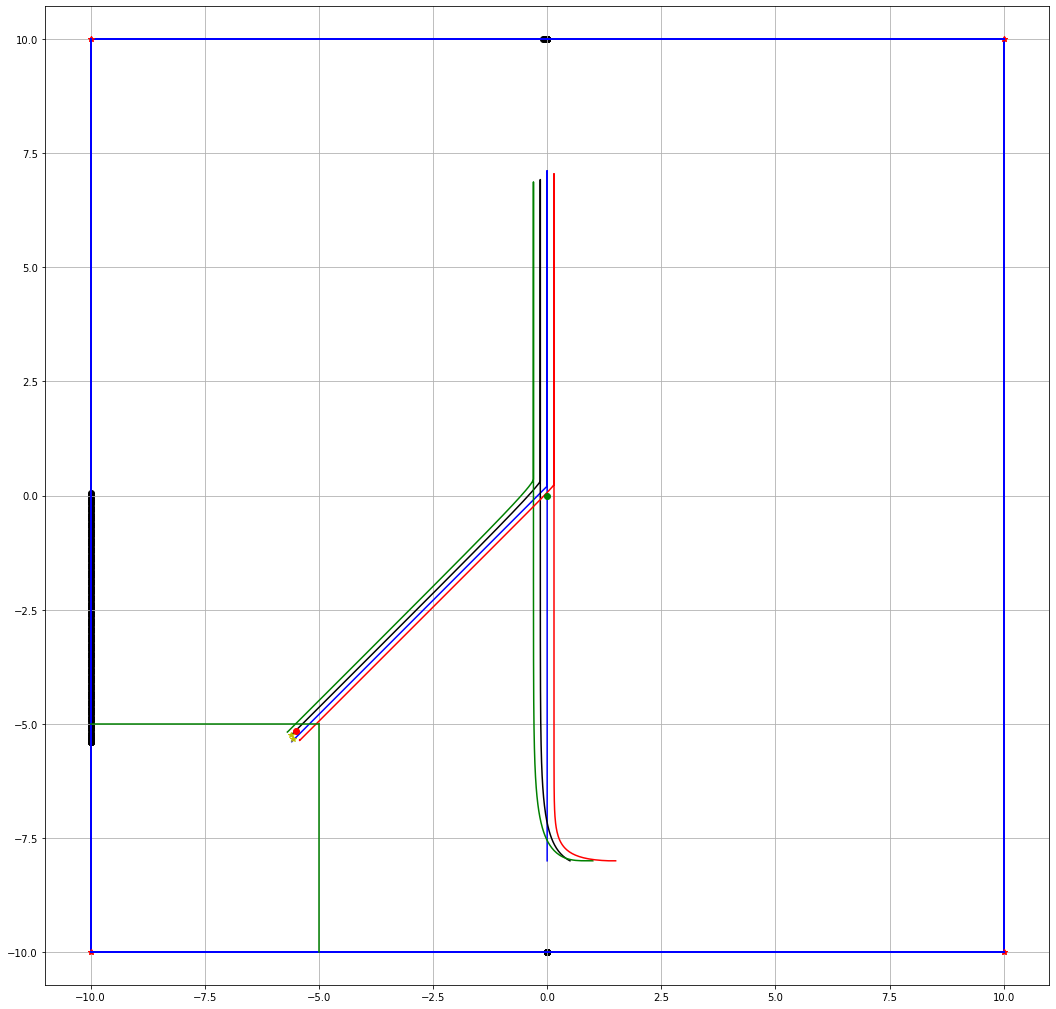

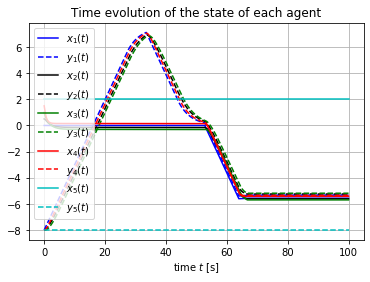

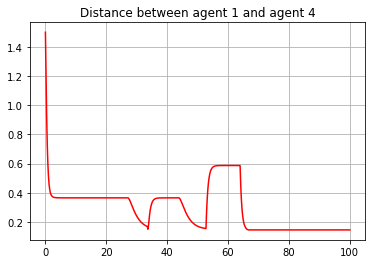

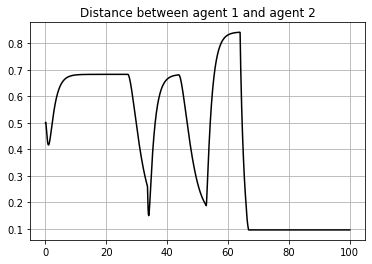

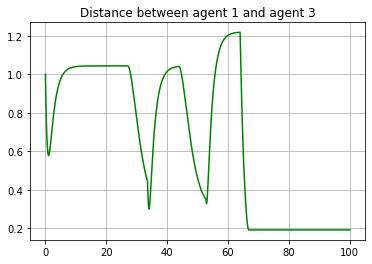

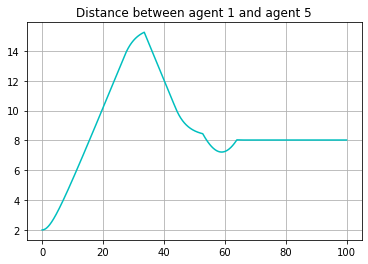

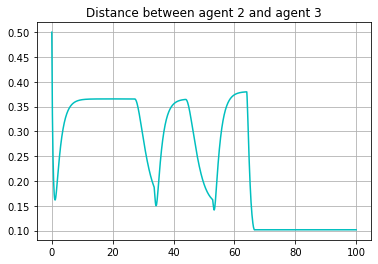

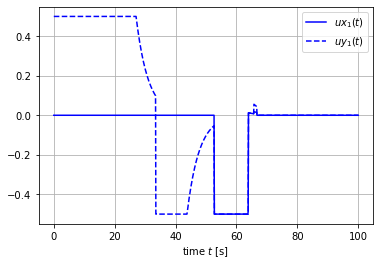

In [3]:
# Plot commands
%matplotlib inline 
#%matplotlib notebook

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,18))

#plt.figure(figsize=(1,1))
ax.axis('equal')
xdim, ydim = 10, 10
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.grid()


# Plots walls and obstacles
world.plot()

# Plots point, closest point and distance
#plt.plot(point[0], point[1], marker='o', color='r')
#plt.plot(closest_pt[0], closest_pt[1], marker='*', color='k')
#plt.plot( [closest_pt[0], point[0]], [closest_pt[1], point[1]], color='k')

plt.plot(x1, y1, label='$x_1(t), y_1(t)$', color='b')
plt.scatter(cpx1, cpy1, label='$cpx_1(t), cpy_1(t)$', marker='o', color='k')
plt.plot(x2, y2, label='$x_2(t), y_2(t)$', color='k')
plt.plot(x3, y3, label='$x_3(t), y_3(t)$', color='g')
plt.plot(x4, y4, label='$x_4(t), y_4(t)$', color='r')
plt.plot(x5, y5, label='$x_5(t), y_5(t)$', color='c')
plt.plot((-10,-5),(-5,-5), color='g')
plt.plot((-5,-5),(-5,-10), color='g')
plt.plot(food[1][0], food[1][1], marker='o', color='r')
plt.plot(food[2][0], food[2][1], marker='o', color='g')
if d_mtx[0] == 1:
    plt.plot(state1[0], state1[1], marker='*', color='y')
if d_mtx[1] == 1:
    plt.plot(state2[0], state2[1], marker='*', color='y')
if d_mtx[2] == 1:
    plt.plot(state3[0], state3[1], marker='*', color='y')
if d_mtx[3] == 1:
    plt.plot(state4[0], state4[1], marker='*', color='y')
if d_mtx[4] == 1:
    plt.plot(state5[0], state5[1], marker='*', color='y')


plt.figure()
plt.plot(time, x1, label='$x_1(t)$', color='b')
plt.plot(time, y1, label='$y_1(t)$', color='b', linestyle='dashed')
plt.plot(time, x2, label='$x_2(t)$', color='k')
plt.plot(time, y2, label='$y_2(t)$', color='k', linestyle='dashed')
plt.plot(time, x3, label='$x_3(t)$', color='g')
plt.plot(time, y3, label='$y_3(t)$', color='g', linestyle='dashed')
plt.plot(time, x4, label='$x_4(t)$', color='r')
plt.plot(time, y4, label='$y_4(t)$', color='r', linestyle='dashed')
plt.plot(time, x5, label='$x_5(t)$', color='c')
plt.plot(time, y5, label='$y_5(t)$', color='c', linestyle='dashed')

plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()
plt.title('Time evolution of the state of each agent');

plt.figure()
plt.plot(time, distance41, label='$x_1(t)$', color='r')
plt.grid()
plt.title('Distance between agent 1 and agent 4');

plt.figure()
plt.plot(time, distance21, label='$x_1(t)$', color='k')
plt.grid()
plt.title('Distance between agent 1 and agent 2');

plt.figure()
plt.plot(time, distance31, label='$x_1(t)$', color='g')
plt.grid()
plt.title('Distance between agent 1 and agent 3');

plt.figure()
plt.plot(time, distance51, label='$x_1(t)$', color='c')
plt.grid()
plt.title('Distance between agent 1 and agent 5');

plt.figure()
plt.plot(time, distance23, label='$x_1(t)$', color='c')
plt.grid()
plt.title('Distance between agent 2 and agent 3');
#plt.plot(time, x4, label='$x_4(t)$', color='r')
#plt.plot(time, y4, label='$y_4(t)$', color='r', linestyle='dashed')
#plt.plot(time, x5, label='$x_5(t)$', color='c')
#plt.plot(time, y5, label='$y_5(t)$', color='c', linestyle='dashed')

plt.figure()
plt.plot(time, ux1, label='$ux_1(t)$', color='b')
plt.plot(time, uy1, label='$uy_1(t)$', color='b', linestyle='dashed')
plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()

print("Results:")

In [4]:

# # x1 = np.sum(np.square(self.scan_1),axis=1)
# # x2 = np.sum(np.square(self.scan_2),axis=1)

# # for n in range(len(self.scan_1)):
# #     prod = 2*np.dot(self.scan_1[n], np.transpose(self.scan_2))
# #     num = np.sqrt((x1[n]-prod+x2))
# #     id=np.argmin(num, axis=0)
# #     #print(id)
# #     correspondences[n]={'point_in_pc_1':[self.scan_1[n][0], self.scan_1[n][1], self.scan_1[n][2]], 'point_in_pc_2':[self.scan_2[id][0], self.scan_2[id][1], self.scan_2[id][2]], 'dist2':num[id]}

# p1=(1,2)
# p2=(3,4)
# p3=(2,3)
# p4=(10,10)
# p5=(20,1)
# points_vec = np.array([p1,p2,p3,p4,p5])
# #print(len(points_vec))
# #print(points_vec[0])

# c_mtx = np.zeros((5))
# d_mtx = np.zeros((5))

# for i in range(0,len(points_vec)-1):
#     #print(i+1,',',range(i+1,4))
#     if d_mtx[i]==0: #para nao volatr a verificar -> pensar como implementar isto
#         for j in range(i+1,4):
#             dist = np.sqrt( (points_vec[i][0] - points_vec[j][0])**2 + (points_vec[i][1] - points_vec[j][1])**2 )
#             #print('i:',i+1,'j:',j+1,'dist:',dist)
#             if dist < 2:
#                 c_mtx[i]=1
#                 c_mtx[j]=1
#                 print('Colision between drone', i+1, 'and drone', j+1,'!!', ' -> dist =', dist)
# d_mtx = c_mtx
# print(d_mtx)


# plt.figure()
# plt.plot(p1[0], p1[1], marker='o', color='r')
# plt.plot(p2[0], p2[1], marker='o', color='g')
# plt.plot(p3[0], p3[1], marker='o', color='b')
# plt.plot(p4[0], p4[1], marker='o', color='y')
# plt.plot(p5[0], p5[1], marker='o', color='c')
# plt.grid()

# #distance = np.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )
# #print('distance:',distance)
# #dist = np.linalg.norm(points_vec,2)
# #print('dist:',dist)
# index of 'i' in alphabets

# alphabets list
# alphabets = ['a', 'e', 'i', 'o', 'g', 'l', 'i', 'u']

# # index of 'i' in alphabets
# index = alphabets.index('e')   # 1

# print('The index of e:', index)

# # 'i' after the 4th index is searched
# index = alphabets.index('i', 2)   # 6

# print('The index of i:', index)

# # 'i' between 3rd and 5th index is searched
# index = alphabets.index('i', 3, 5)   # Error!
# if index:
#     print('The index of i:', index)

w_food_mtx_2 = np.zeros((5))
w_food_mtx_2[1] = 1
w_food_mtx_2[3] = 1
print(K)
print(((xi32+b23)))
print('result:',2*K @ ((xi32+b23)))

if not 2 in w_food_mtx_2:
    print('but its made of all')

if 1 in w_food_mtx_2:
    print('tem um 1')
    result = np.where(w_food_mtx_2 == 1)
    print(result[0][0])
    print(result[0][1])
    #print(w_food_mtx_2.index(1))

print(0.0006 + 0.986430573)
print(0.0006 \
    + 0.986430573)

[[1 0]
 [0 1]]
[0.06805967 0.06008837]
result: [0.13611934 0.12017675]
but its made of all
tem um 1
1
3
0.9870305730000001
0.9870305730000001
